# Yelp Review Classification

This notebook will be using the public Yelp dataset:
https://www.yelp.com/dataset

Here we will be building a support vector machine (SVM) classifier that is modeled using sentiment analysis using texts from reviews. This model will then be able to predict how many star ratings a given review might get.

In [1]:
import json 
import numpy as np
import pandas as pd

In [ ]:
# may take several minutes to parse 3GB of JSON; alternatively you can skip this cell and use the shortened dataset
file = 'dataset/review.json'
chunks = pd.read_json(file, lines=True, chunksize=10000)
df = pd.concat(chunks, ignore_index=True)
df[:300000].to_csv("mini_yelp.csv")

Although the entire dataset contains over 4 million reviews, to save memory, I'm only using the first 500,000 of these reviews, which will be provided along with this notebook. However, using the entire dataset would lead to a more powerful model.

In [2]:
yelp = pd.read_csv("mini_yelp.csv", low_memory=False)
yelp = yelp.drop('Unnamed: 0', 1)

In [3]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw


As we can see above, each row in the reviews dataset consists of a business ID, review ID, user ID, along with how many users have rated each review as 'cool', 'funny', or 'useful', along with the star rating the user gave, and finally, the text of the review. Although we can incorporate other variables by connecting these IDs from the business and user datasets to make a more advanced model, we'll just start by using two variables for our first classification task. We will be using the review texts for our x-value, and be using these to predict star ratings, our y-value.

In [4]:
texts = yelp["text"]
stars = yelp["stars"]

When we train our classification model, we want to make sure that we have an even distribution of possible outcomes, otherwise this may lead to bias. In this case, our outcomes are the five different types of star ratings, so let's check how these are distributed in our dataset:

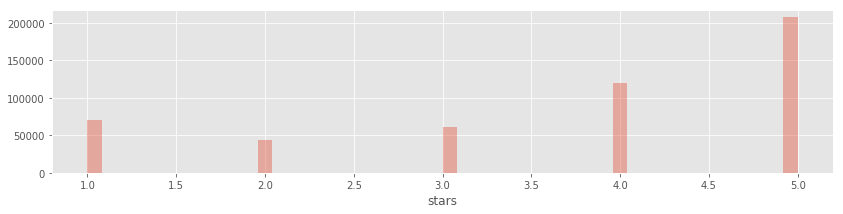

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
% matplotlib inline

plt.figure(figsize=(14,3))
sns.distplot(stars, kde=False)

In [6]:
from collections import Counter
print(Counter(stars))

Counter({5.0: 206714, 4.0: 119157, 1.0: 70371, 3.0: 60514, 2.0: 43244})


We can immediately see that 5-star reviews are hugely overrepresented, while 2 and 3-star reviews tend to be underrepresented. We want an even number of data points across each category, so let's run a quick function that will throw out the reviews in our overrepresented categories until we have a balanced distribution.

In [6]:
from collections import Counter
 
def balance_classes(xs, ys):
    freqs = Counter(ys)
 
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [7]:
balanced_x, balanced_y = balance_classes(texts,stars)
print(Counter(balanced_y))

Counter({1: 43244, 2: 43244, 3: 43244, 4: 43244, 5: 43244})


Our dataset is now clean and ready to be prepared for analysis. Machine learning models work using numbers instead of strings, so we need to apply some sort of natural language processing algorithm to turn our collection of texts into meaningful numbers. 

The most common method is to use the Bag-of-Words (BoW) algorithm, which simply parses the entire dataset and creates a word-count table in the form of a sparse matrix counting up the number of times each word popped up in our collection of texts. This works, but instead we you use the more sophisticated Term Frequency Inverse Document Frequency (TF-IDF) algorithm, which also counts up the number of times a word pops up, but instead of storing just the raw word count in each matrix, it assigns a normalized score to each word based on word frequency. Here is a more detailed resource about the subject: https://deeplearning4j.org/bagofwords-tf-idf

The Sklearn library includes a singular function that will account for the tokenization (converting the strings of texts into strings of each individual word) and vectorization (converting these strings into a sparse matrix of TF-IDF scores). All we have to do is specify an 'n-gram range', which allows us to represent multiple words that represent one idea into one element. For example, when we set the n-gram range to 2, instead of counting "not" and "good" as two words, we'll count "not good" as one word.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2)) # may take a few minutes
vectors = vectorizer.fit_transform(balanced_x)

Like we do with all machine learning models, we now need to partition our data into the training set (the section of the data that the model learns from) and the test set (the section of the data that is NOT used to train the model and instead is used to test the model's accuracy). We will use a test size of 0.33, meaning we'll train the model on 2/3 of the dataset, and test it on the last 1/3 of the remaining data.

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.33, random_state=42)

Finally, we can start training our machine learning model. We will be using a support vector machine (SVM) classifier: https://en.wikipedia.org/wiki/Support_vector_machine

We don't need to necessarily know the math behind it to apply this model (although it certainly is useful to know). All we need to do is pass in a set of features from our training set (x_train, our collection of vectorized review) and a set of labels from our training set (y_train, the star ratings associated with each review) into the LinearSVC class provided to us by the Scikit-learn package.

In [11]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Our model is now complete. 

We can try applying the model to some of the examples in our test set to see how well it classifies them. 

In [12]:
predictions = classifier.predict(X_test)
print(list(predictions[:20]))
print(y_test[:20])

[2, 3, 4, 1, 5, 1, 5, 5, 1, 4, 2, 3, 1, 3, 3, 2, 1, 2, 2, 3]
[1, 3, 2, 1, 4, 3, 5, 5, 3, 4, 3, 3, 1, 4, 3, 2, 1, 3, 1, 4]


The first list represents the model's predictions of star ratings for the first twenty reviews, while the second list represents the actual star ratings of the first twenty reviews. We can also calculate the accuracy score when the model is applied to the entire test set:

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.611424887531


Our model guesses the correct star rating with a 61% accuracy. This is actually pretty decent when considering that  the model is choosing between five different categories. Imagine if you were given a lukewarm review and had to choose whether or not that review gave a 2-star, 3-star, or 4-star rating. That would be difficult task even for a human. We can construct a confusion matrix which will tell us how often one category of rating may be confused with another.

In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[11188  2343   411    99   129]
 [ 3509  7126  3028   525   215]
 [  798  2958  7092  2962   588]
 [  209   535  2606  7387  3471]
 [  160   117   393  2670 10834]]


The x-axis represents the SVM classifier predicted, while the y-axis represents what the actual star rating was. For example, the first row represents what predicted as having one-star while the columns represent how many stars the review actually received, and the second row represents what the SVM predicted as having two-stars, third-row as three-stars, and so on. 

So we can see using this that the model is pretty accurate for guessing extremes (1 or 5-stars), but struggles more with determining whether or not a more lukewarm review should be classified as either a 2-star, 3-star, or 4-star review.

To gain more insight into how our SVM model makes its predictions, we can look into how our model calculates its prediction by seeing what features (in this case, the features are words) are weighted highest and lowest in determining how to classify each review. We can order all the words by feature weight.

In [ ]:
def print_top20_best(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.coef_[i])[-20:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top20)))
        
print("Highest Weighted Words for N-Star Reviews:")
print_top20_best(vectorizer, classifier, classifier.classes_)

Highest Weighted Words for N-Star Reviews:
1: avoid, joke, worse, not recommend, could give, rude, stay away, never, no stars, scam, zero, never again, awful, disgusting, zero stars, will never, terrible, horrible, one star, worst
2: subpar, so so, unfortunately, won be, unimpressed, bland, not, to like, at best, mediocre, stars because, not very, disappointed, not worth, experienced better, second star, disappointing, meh, two star, two stars
3: not great, to love, alright, not so, okay, aber, back but, other hand, though, three star, average, an ok, but, ok, decent, stars, again but, not bad, however, three stars
4: even better, chandelier, the better, goodness, not fancy, ru, tasty, off star, above average, shakes, makes up, nice, delicious, star because, ikea, really good, my only, star off, good, four stars
5: gem, honest, wonderful, hands down, every, love, be disappointed, thanks, so good, not disappointed, incredible, perfect, great, outstanding, excellent, not only, fantastic,

In [ ]:
def print_top20_worst(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.coef_[i])[:20]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top20)))

print("Lowest Weighted Words for N-Star Reviews:")
print_top20_worst(vectorizer, classifier, classifier.classes_)

Lowest Weighted Words for N-Star Reviews:
1: stars, great, two stars, stars because, delicious, excellent, amazing, good, awesome, best, love, not bad, but, decent, friendly, fantastic, nice, tasty, loved, enjoyed


Finally, we can also generate these in the form of a Matplotlib/Seaborn plot that graphs the highest and lowest ranking words by their coefficients. We'll generate a plot for each classification

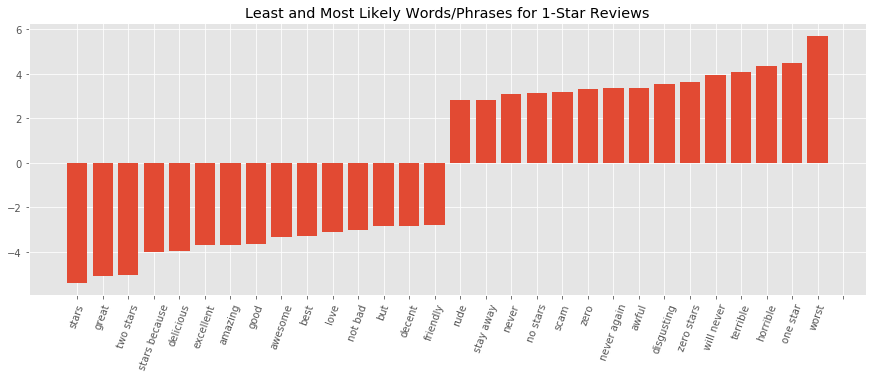

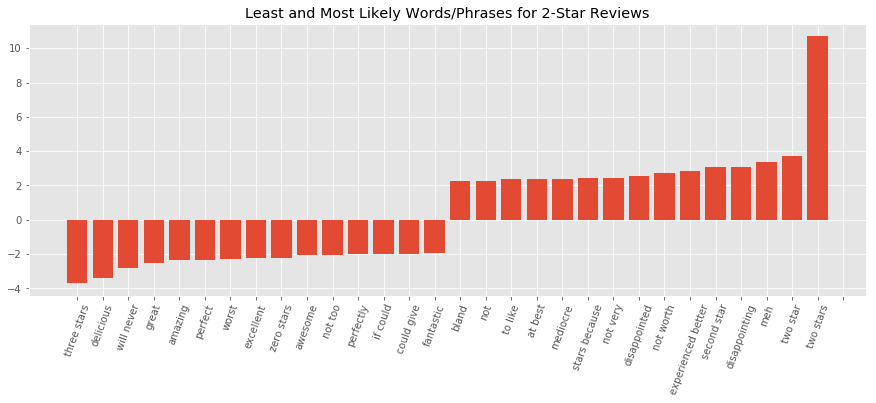

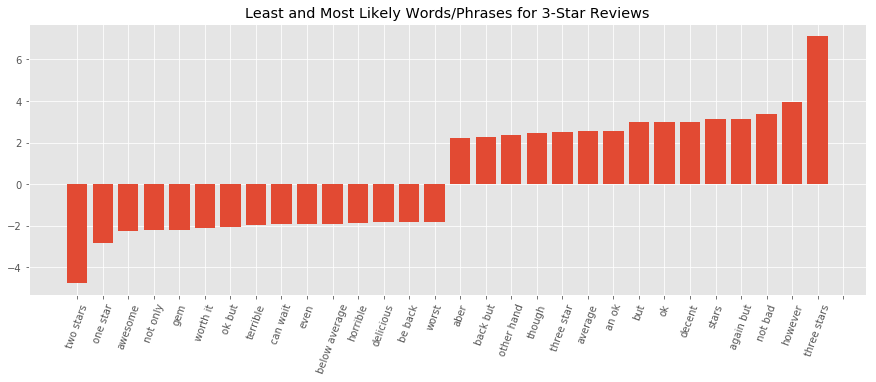

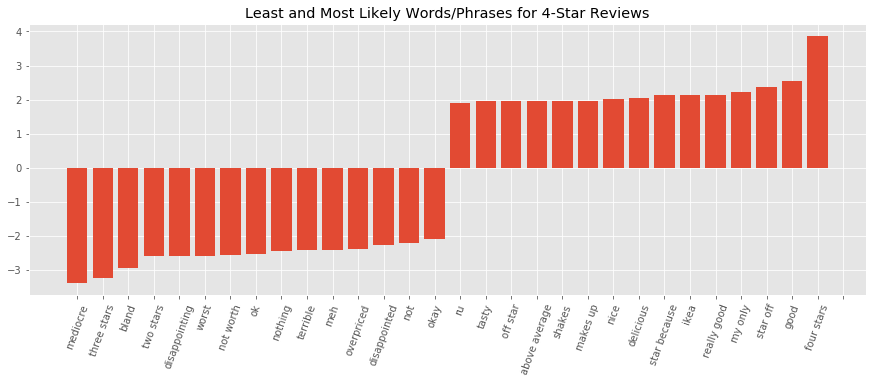

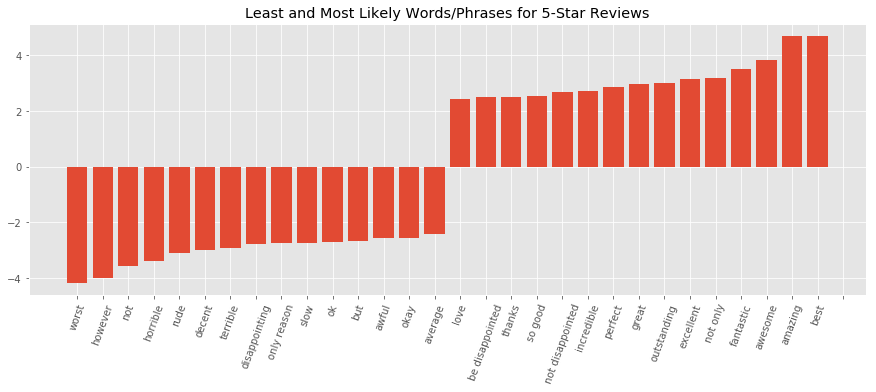

In [20]:
def plot_coefficients(classifier, feature_names, stars, top_features=15):
    coef = classifier.coef_[stars - 1]
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(2 * top_features), coef[top_coefficients])
    labels = []
    for i in top_coefficients:
        labels.append(feature_names[i])
    plt.xticks(np.arange(0, 1 + 2 * top_features), labels, rotation=70)
    plt.title("Least and Most Likely Words/Phrases for " + str(stars) + "-Star Reviews")
    plt.show()

for i in range(1,6):
    plot_coefficients( classifier, vectorizer.get_feature_names(), i )